# Brainstorming

Potential questions:
1. emotions based on nationality/race --> Distilbert
2. rationality/objectivity based on profession --> ??
3. emotions based on Media platform

In [ ]:
%pip install -qU 'google-genai>=1.0.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 1.3 MB/s eta 0:00:00


In [2]:
import json
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from google import genai
import scipy.stats as sts
from google.genai import types
import matplotlib.pyplot as plt
from IPython.display import Markdown

# Gemini

In [3]:
from google.colab import userdata
key = userdata.get('API_Key')
client = genai.Client(api_key=key)

In [4]:
model_id = "gemini-2.0-flash-lite"

In [5]:
example_response = client.models.generate_content(model=model_id,
                                                  contents = 'Explain the relationship between the Poisson distribution and the Exponential distribution\
                                                  and when to use each.',
                                                  config=types.GenerateContentConfig(temperature=0.5))
Markdown(example_response.text)

## The Relationship Between Poisson and Exponential Distributions

The Poisson and Exponential distributions are closely related, representing two sides of the same coin when dealing with **random events occurring over time or space**.  They are essentially **inverses** of each other in a specific context.

Here's a breakdown of their relationship:

*   **Poisson Distribution:**
    *   **Describes:** The number of events occurring within a **fixed interval** (time, space, etc.).
    *   **Parameters:**  The average rate of events, denoted by  λ (lambda), which represents the average number of events per interval.
    *   **Probability Mass Function (PMF):**  P(X = k) = (λ^k * e^(-λ)) / k!  where:
        *   X is the random variable representing the number of events.
        *   k is the number of events.
        *   e is the base of the natural logarithm (approximately 2.71828).
        *   k! is the factorial of k (k * (k-1) * ... * 2 * 1).
    *   **Example:** The number of customers arriving at a store in an hour, the number of phone calls received per day, the number of defects found in a roll of fabric.

*   **Exponential Distribution:**
    *   **Describes:** The time or space **between** consecutive events.
    *   **Parameters:**  The same average rate of events, λ (lambda), as the Poisson distribution. Alternatively, it can be parameterized by the mean time between events, which is 1/λ.
    *   **Probability Density Function (PDF):**  f(t) = λ * e^(-λt)  where:
        *   t is the random variable representing the time or space between events.
        *   λ is the rate of events (same as in Poisson).
        *   e is the base of the natural logarithm.
    *   **Example:** The time between customer arrivals, the time until a lightbulb burns out, the distance between flaws in a cable.

**The Key Connection:**

The Exponential distribution is the **continuous counterpart** to the discrete Poisson distribution. If events occur randomly and independently at a constant average rate (λ), then:

*   The number of events in a fixed interval follows a Poisson distribution with parameter λ.
*   The time (or space) between consecutive events follows an Exponential distribution with parameter λ.

**Analogy:**

Imagine a stream of cars passing a point on a highway.

*   **Poisson:**  You're interested in how many cars pass in a 1-minute interval (fixed time).
*   **Exponential:** You're interested in how long (in seconds) it takes for the next car to arrive after the last one passed (time between events).

**When to Use Each Distribution:**

| Feature          | Poisson                                         | Exponential                                           |
| ---------------- | ----------------------------------------------- | ----------------------------------------------------- |
| **Focus**        | Number of events in a fixed interval           | Time/space between events                             |
| **Variable**     | Discrete (whole numbers)                         | Continuous (can be any value)                         |
| **Question Type** | "How many...?" within a given time/space        | "How long until...?" or "What's the time between...?" |
| **Use Case**     | Counting occurrences, e.g., calls, defects, arrivals | Waiting times, e.g., customer service, equipment failure |

**In summary:**

*   Use the **Poisson distribution** when you want to model the *number* of events happening within a specific period or area.
*   Use the **Exponential distribution** when you want to model the *time or distance* between those events.
*   Both distributions are based on the same underlying assumption of a constant rate of random events.  They are essentially two ways of looking at the same phenomenon.  Knowing one helps you understand the other.


# roBERTa

In [7]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

In [8]:
# From the model's documentation
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def preprocess(text):
    '''
    Preprocesses text for sentiment analysis.
    '''
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def evaluate_sentiment(text):
    '''
    Returns a list of scores for negative, neutral, and positive sentiment.
    '''
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = softmax(output[0][0].detach().numpy())
    return scores

test_sentiment = evaluate_sentiment("AI can enhance humans productivity.")
print(f'Negative: {test_sentiment[0]},  Neutral: {test_sentiment[1]}, Positive: {test_sentiment[2]}')

Negative: 0.007381913717836142,  Neutral: 0.1323302835226059, Positive: 0.8602878451347351


## Generating Responses and Doing the Sentiment Analysis

In [25]:
prompt_google = "As the CEO of Google, describe in one paragraph to what extent the company can rely on AI tools for its software projects."
prompt_startup = "As the founder of a tech startup, describe in one paragraph to what extent the company can rely on AI tools for its software projects."

In [38]:
num_responses = 200
rate_limit = 15

output_file = 'responses.json'
responses_google = []
responses_startup = []
sentiment_score_google = []
sentiment_score_startup = []

for i in tqdm(range(num_responses)):
    # Choose one of the two prompts with probability 0.5 each
    prompt = str(np.random.choice([prompt_google, prompt_startup]))
    response = client.models.generate_content(model=model_id,
                                              contents = prompt,
                                              config=types.GenerateContentConfig(temperature=0.5))

    if prompt == prompt_google:
        responses_google.append(response.text)
        sentiment_score_google.append([evaluate_sentiment(response.text)])
    else:
        responses_startup.append(response.text)
        sentiment_score_startup.append(evaluate_sentiment(response.text))
    # Pause for one minute when the requests limit is reached
    if i%rate_limit == 0 and i != 0:
        time.sleep(60)

100%|██████████| 200/200 [18:56<00:00,  5.68s/it]


In [48]:
# selecting the positive probability
positive_score_google = np.array(sentiment_score_google)[:, 2]
positive_score_startup = np.array(sentiment_score_startup)[:, 2]

In [51]:
# Writing the responses and their scores into a json file
with open(output_file, 'w') as f:
    json.dump({'responses_google': responses_google, 'responses_startup': responses_startup,
               'positive_score_google': positive_score_google.tolist(), 'positive_score_startup': positive_score_startup.tolist()},
              f, indent=4)

## Examining the Sentiment Scores

In [60]:
# Descriptive Statistics
count_google = len(positive_score_google)
count_startup = len(positive_score_startup)
mean_google = np.mean(positive_score_google)
mean_startup = np.mean(positive_score_startup)
med_google = np.median(positive_score_google)
med_startup = np.median(positive_score_startup)
print(f'Number of responses from Google CEO: {count_google}')
print(f'Number of responses from Startup Founder: {count_startup}')

Number of responses from Google CEO: 89
Number of responses from Startup Founder: 111


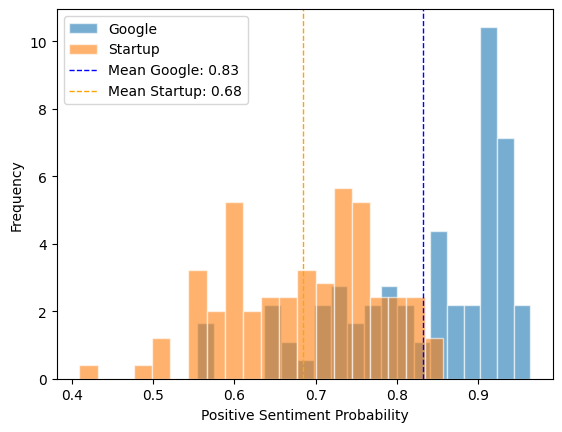

In [61]:
plt.figure()
plt.hist(positive_score_google, density=True, edgecolor='white',
         bins=20, alpha=0.6, label='Google')
plt.hist(positive_score_startup, density=True, edgecolor='white',
         bins=20, alpha=0.6, label='Startup')
plt.axvline(mean_google, color='blue', linestyle='dashed',
            linewidth=1, label=f'Mean Google: {mean_google:.2f}')
plt.axvline(mean_startup, color='orange', linestyle='dashed',
            linewidth=1, label=f'Mean Startup: {mean_startup:.2f}')
plt.legend()
plt.xlabel('Positive Sentiment Probability')
plt.ylabel('Frequency')
plt.show()

# Try Empath